# Pystan implementation of hierarchical model 

In [1]:
import sys
import numpy as np
import pystan
import pandas as pd
import scipy.stats
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Generate the fake data

In [27]:
# Define the constants. 
n_div = 1000 
n_tot = np.random.gamma(10, 20, size=n_div).astype(int)
n1 = np.random.binomial(n_tot, p=0.5)
n2 = n_tot - n1

# Convert to intensity. 
alpha = 200
I1 = n1 * alpha #+ np.random.normal(loc=alpha, scale=50)
I2 = n2 * alpha #+ np.random.normal(loc=alpha, scale=50)

# Compute the squared difference adn summed intensity
summed = I1 + I2 
sq_diff = (I1 - I2)**2
summed_range = np.logspace(4, 5, 500)

# Assemble as a dataframe.
data = pd.DataFrame(np.array([I1, I2, summed, sq_diff]).T, 
                   columns=['I1', 'I2', 'summed', 'sq_diff'])

# Compute the fit. 
ground_truth = pd.DataFrame(np.array([summed_range, alpha * summed_range]).T,
                           columns=['summed_range', 'theo'])

Generate the plot 

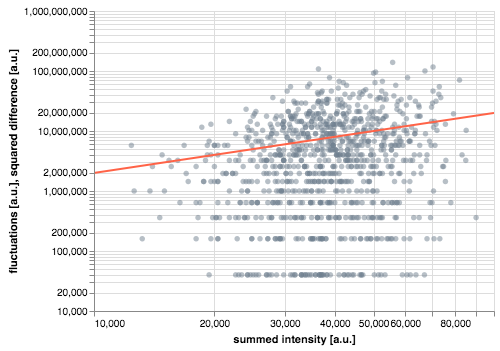

In [28]:
baseplot = alt.Chart(data[data['sq_diff'] != 0])
measurements = baseplot.mark_circle(color='slategray', opacity=0.5).encode(
        x=alt.X('summed', title='summed intensity [a.u.]', scale={'type':'log'}),
        y=alt.Y('sq_diff',title='fluctuations [a.u.]', scale={'type':'log'}))
 
fit = alt.Chart(ground_truth).mark_line(color='tomato').encode(
    x=alt.X('summed_range', title='summed intensity [a.u.]', scale={'type':'log'}),
    y=alt.Y('theo', title='squared difference [a.u.]', scale={'type':'log'}))

(measurements + fit).interactive()

Define a pystan model assuming a gaussian approximation of binomial

In [57]:
model_code = """
functions{
    // Define a custom function for a marginalized Homoscedasitc normal. 
    real MarginalizedNormal_lpdf(vector x, vector mu) {
    real lprob;
    vector[num_elements(x)] prob;
    int k;
    k = num_elements(x); 
    for (i in 1:k) {
        prob[i] = (x[i] - mu[i])^2;
    }
    lprob = -0.5 * k * sum(log(prob));
    return lprob;
    }
    }
data {
    int N; // Number of data points.
    vector[N] I1; 
    vector[N] I2;
    }
    
parameters {
    vector<lower=0>[N] ntot;  
    vector<lower=0>[N] n1;
    real<lower=195, upper=205>alpha;

    }
model {
    vector[N] mu_1;
    vector[N] mu_2;
    ntot ~ normal(100, 10);
    n1 ~ normal(ntot / 2, ntot /4);
    alpha ~ normal(200, 10); 
    for (i in 1:N) { 
        mu_1[i] = alpha * n1[i];
        mu_2[i] = alpha * (ntot[i] - n1[i]);
    }
 
    I1 ~ MarginalizedNormal(mu_1);
    I2 ~ MarginalizedNormal(mu_2);
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d91e747b7a3501cbfc36b8d07ee50f1 NOW.


In [58]:
# Define the data dictionary and try to sample.
data_dict = {'N':n_div, 'I1':I1, 'I2':I2}
samples = model.sampling(data=data_dict, iter=1000, chains=2)

In [59]:
samples

Inference for Stan model: anon_model_3d91e747b7a3501cbfc36b8d07ee50f1.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ntot[0]     0.42    0.16   0.16   0.25   0.25   0.42   0.58   0.58      1    nan
ntot[1]     1.97    0.11   0.11   1.86   1.86   1.97   2.08   2.08      1    nan
ntot[2]     1.41    0.49   0.49   0.91   0.91   1.41    1.9    1.9      1    nan
ntot[3]     1.07    0.61   0.61   0.46   0.46   1.07   1.68   1.68      1    nan
ntot[4]     0.72    0.13   0.13    0.6    0.6   0.72   0.85   0.85      1    nan
ntot[5]     2.36    1.86   1.86    0.5    0.5   2.36   4.22   4.22      1    nan
ntot[6]     0.48    0.13   0.13   0.35   0.35   0.48   0.61   0.61      1    nan
ntot[7]     0.61    0.14   0.14   0.47   0.47   0.61   0.75   0.75      1    nan
ntot[8]      2.2    0.72   0.72   1.49   1.49    2.2   2.92   2.92      1    nan
nto

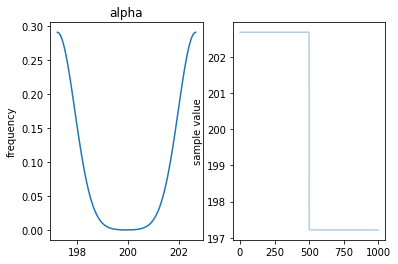

In [60]:
_ = samples.plot(pars=['alpha'])